# Pandas Cheatsheet #

This notebook includes some of the common pandas functions (and others) for data mining and analysis.

## Exploratory Data Analysis ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
matplotlib.style.use('ggplot')

***
### Data Summary ###
display a summary of the df with specified categorical column names

In [2]:
def cat_col_summary(df, categorical_cols):
    for val in categorical_cols:
        print('total counts: ', df[val].count())
        print(df[val].value_counts())
        print('-'*40)

# print out a summary of the dataframe
def df_summary(df, categorical_cols):
    print('dim of table:')
    print(df.shape, '\n')
    
    print('first few rows of the table:')
    print('='*40)
    print(df.head(), '\n')
    
    print('count of null values:')
    print('='*40)
    print(df.isnull().sum(), '\n')
    
    print('summary of numeric values')
    print('='*40)
    print(df.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]), '\n')
    
    print('\nsummary of categorical values')
    print('='*40)
    cat_col_summary(df, categorical_cols)

In [3]:
# example 1
df = pd.read_csv('../data/conversion_data.csv')
categorical_cols = ['country', 'source']
df_summary(df, categorical_cols)

dim of table:
(316200, 6) 

first few rows of the table:
  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0 

count of null values:
country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64 

summary of numeric values
                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000

***

### Input Variable Value Distribution ###
get population (counts) of a given value bucket breakdown

In [4]:
df['age'].value_counts(bins=[0, 20, 30, 40, 80, 150], sort=False)

(-0.001, 20.0]     35568
(20.0, 30.0]      132283
(30.0, 40.0]      108269
(40.0, 80.0]       40078
(80.0, 150.0]          2
Name: age, dtype: int64

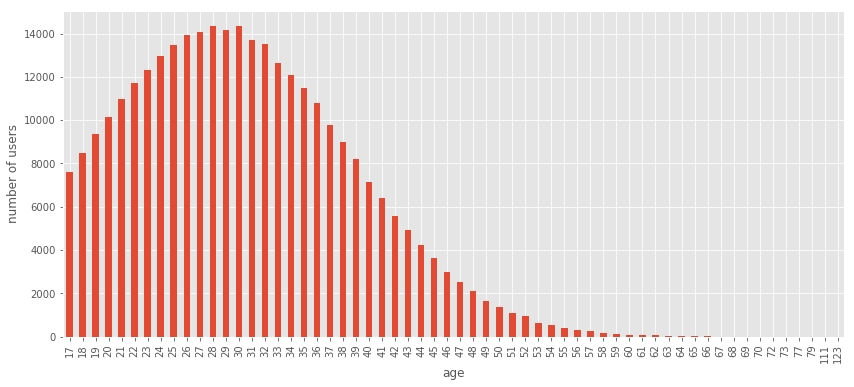

In [5]:
chart = df['age'].value_counts(sort=False).plot(kind='bar', figsize=(14, 6))
chart.set_ylabel('number of users')
chart.set_xlabel('age')

***
### Test/Control Distribution by Input Variable ###
compare `y=1` and `y=0` counts by a given input variable

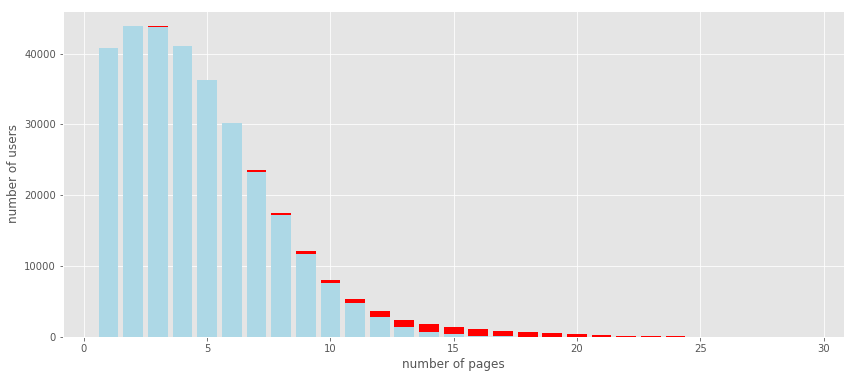

In [6]:
# adapted from Sayan Sanyal's code
fig, ax = plt.subplots(figsize=(14, 6))

page_range = np.arange(0, 30)
converts = df[df["converted"]==1]['total_pages_visited'].value_counts(bins=list(page_range), sort=False)
holdouts = df[df["converted"]==0]['total_pages_visited'].value_counts(bins=list(page_range), sort=False)
ind = converts.index

p1 = plt.bar(ind.right, converts.values, color='red', bottom=holdouts)
p2 = plt.bar(ind.right, holdouts.values, color='lightblue')
plt.ylabel('number of users')
plt.xlabel('number of pages')
plt.show()

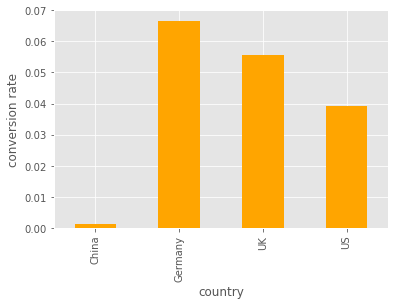

In [7]:
converts = df[df["converted"]==1].groupby('country').size()
holdouts = df[df["converted"]==0].groupby('country').size()
chart = (converts/holdouts).plot(kind='bar', color='orange')
chart.set_ylabel('conversion rate')

***

### Date Manipulation ###
*sample question*:  
check if a user has signed in consecutively for $n$ days.

In [24]:
# clean up data
df = pd.read_csv('../data/consec_days.csv')
df['Time'] = pd.to_datetime(df['Time'])
df.sort_values(['Time', 'User'], inplace=True)
df.reset_index(drop=True, inplace=True)

scenario 1: check against a given time window

In [25]:
start = datetime(2016, 12, 1)
end = datetime(2016, 12, 8)
df_window = df[(df['Time']>=start) & (df['Time']<end)].copy()
df_window['day'] = df_window['Time'].apply(lambda x: x.day)
(df_window.groupby('User')['day'].nunique()==7).sum()

1

scenario 2: check for $n$ days given a log

In [26]:
def consecutive_week(group, n):
    day_diffs = np.diff(group['Time'].unique()).astype('timedelta64[D]').astype(int)
    consec_day_pattern = np.ones(n)
    x = len(day_diffs) - len(consec_day_pattern) + 1
    for i in range(x):
        if (day_diffs[i:i+n] == consec_day_pattern).all():
            return True
    return False    

df.groupby('User').apply(consecutive_week, 6).sum()

2

scenario 3: get longest consecutive sign-ins for a given user

In [27]:
import itertools
unique_dates = np.sort(df[df['User'] == 2]['Time'].unique())
date_diff = np.diff(unique_dates).astype('timedelta64[D]').astype(int)
max(sum(1 for _ in l) for n, l in itertools.groupby(date_diff) if n == 1)

6

***

### TABLE JOIN ###
*sample question 1*:  
find the most common user age for each country

In [12]:
df = pd.read_csv('../data/conversion_data.csv')
counts = df.groupby(['country', 'age'], as_index=False)['new_user'].count()
counts.columns = ['country', 'age', 'count']
max_counts = pd.DataFrame(counts.groupby('country')['count'].max())
counts = pd.merge(max_counts, counts)
counts = counts[['country', 'age', 'count']]
counts

,country,age,count
0,China,30,3522
1,Germany,25,606
2,UK,27,2218
3,US,28,8148


*sample question 2*:  
look up an foreign key on the same database

In [13]:
df = pd.read_csv('../data/type_conversion.csv')
df_new = df.merge(df[['ID', 'Type']], left_on='Source', right_on='ID')[['ID_x', 'Source', 'Type_y']]
df_new.columns = ['ID', 'Source', 'Source_Type']
df_new.groupby('Source', as_index=False)['ID'].count().sort_values(by='ID', ascending=False).head(5)

,Source,ID
15,47.0,6
0,2.0,5
8,21.0,4
17,51.0,4
14,46.0,4


***
### Other Handy Stuff ###

#### Filtering ####
Different filtering on variable values

In [14]:
df = pd.read_csv('../data/conversion_data.csv')
df_filtered = df[(df['age'] > 20) & 
                 (df['age'] < 26) & 
                 (df['country'].str.contains('U.*'))
                ].groupby(['country', 'age'], as_index=False).count()
df_filtered[df_filtered['new_user'] > 2000][['country', 'age']]

,country,age
4,UK,25
5,US,21
6,US,22
7,US,23
8,US,24
9,US,25


#### Sorting ####
Multi-level sorting

In [15]:
df = pd.read_csv('../data/conversion_data.csv')
df.sort_values(by=['country', 'age'], ascending=[1, 0])[:5]

,country,age,new_user,source,total_pages_visited,converted
168374,China,69,1,Ads,4,0
209080,China,68,0,Seo,5,0
31654,China,67,0,Seo,3,0
84466,China,66,0,Ads,9,0
192772,China,66,1,Ads,8,0


#### Unique Values ####
Number of unique values

In [16]:
df.groupby('country')['age'].nunique()

country
China      53
Germany    48
UK         52
US         58
Name: age, dtype: int64

#### Reset Index ####
Get your multi-level index into a dataframe - one of the best things you can ask for!

In [17]:
age_size = df.groupby('country')['age'].value_counts().to_frame('count').reset_index()
age_size.sort_values('count', ascending=False)[:5]

,country,age,count
153,US,28,8148
154,US,30,8073
155,US,26,7907
156,US,27,7899
157,US,29,7888


#### Crosstab ###
*sample question*:  
find the most common user age for each country

In [18]:
ct = pd.crosstab(df.country, df.age)
ct.stack().groupby(level=0).idxmax()

country
China        (China, 30)
Germany    (Germany, 25)
UK              (UK, 27)
US              (US, 28)
dtype: object

equivalent to... a multi-level `groupby`!

In [19]:
df.groupby(['country', 'age']).size().groupby(level=0).idxmax()

country
China        (China, 30)
Germany    (Germany, 25)
UK              (UK, 27)
US              (US, 28)
dtype: object

***
## Some Scipy for More Fun ##
### Hypothesis Testing ###

In [20]:
from scipy import stats
from scipy.stats import t, binom

alpha = 0.1
n_sample = 15
t_stat = t.ppf(1 - alpha/2, n_sample - 1)
print(t_stat)

binom.ppf(0.95, 100, 0.5)
print(1 - binom.cdf(58, 100, 0.52))

1.76131013577
0.096334668221


In [21]:
t.cdf(2.5, n_sample - 1)

0.98726666769296889

In [22]:
observed_data = [170, 167, 174, 179, 179, 
                 156, 163, 156, 187, 156, 
                 183, 179, 174, 179, 170, 
                 156, 187, 179, 183, 174, 
                 187, 167, 159, 170, 179]
H_0 = 170

t_stat, p_value = stats.ttest_1samp(observed_data, H_0)

# one sided p_value
print('p_value from t-stat: ', 1 - t.cdf(t_stat, len(observed_data) - 1))

# one sided p_value
print('p_value: ', p_value/2)

p_value from t-stat:  0.116816398182
p_value:  0.116816398182


***
### TODOs ###
* cross-tab

ML stuff
* ROC
* confusion matrix